# ADA Project : Milestone 2

## Imports and Data

In [27]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
# Data from RateBeer 'RB'
beers_RB = pd.read_table("./data/RateBeer/beers.csv", sep=",")
breweries_RB = pd.read_table("./data/RateBeer/breweries.csv", sep=",")
users_RB = pd.read_table("./data/RateBeer/users.csv", sep=",")
ratings_RB = pd.read_table("./data/RateBeer/ratings.csv", sep=",")

In [3]:
# Data from BeerAdvocate 'BA'
beers_BA = pd.read_table("./data/BeerAdvocate/beers.csv", sep=",")
breweries_BA = pd.read_table("./data/BeerAdvocate/breweries.csv", sep=",")
users_BA = pd.read_table("./data/BeerAdvocate/users.csv", sep=",")
ratings_BA = pd.read_table("./data/BeerAdvocate/ratings.csv", sep=",")

In [4]:
# Data from BA and RB mixed (by us)
# ratings_mixed = pd.read_table("./data/ratings_BAm_RBm.csv", sep=",")
ratings_mixed_sample = pd.read_table("./data/ratings_BAm_RB_sample.csv", sep=",")

In [5]:
# Data from MixedDataset 'MD'
beers_MD = pd.read_table("./data/matched_beer_data/beers.csv", sep=",")
breweries_MD = pd.read_table("./data/matched_beer_data/breweries.csv", sep=",")
users_MD = pd.read_table("./data/matched_beer_data/users.csv", sep=",")
users_approx_MD = pd.read_table("./data/matched_beer_data/users_approx.csv", sep=",")
ratings_MD = pd.read_table("./data/matched_beer_data/ratings.csv", sep=",")

C:\Users\swann\AppData\Local\Temp\ipykernel_38580\3246452614.py:2: DtypeWarning: Columns (0,1,2,3,4,5,8,10,11,12,13,15,16,17,18,19,20,23,25,26,27,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  beers_MD = pd.read_table("./data/matched_beer_data/beers.csv", sep=",")
C:\Users\swann\AppData\Local\Temp\ipykernel_38580\3246452614.py:6: DtypeWarning: Columns (0,1,2,3,5,7,8,9,10,11,13,17,18,19,20,22,24,25,26,27,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_MD = pd.read_table("./data/matched_beer_data/ratings.csv", sep=",")


## Seasonal analysis of the number of reviews per type of beer

In [16]:
df_samp_of_samp = ratings_mixed_sample.sample(frac=.01, random_state=42)
print(len(df_samp_of_samp))
print(df_samp_of_samp.columns)
print(len(df_samp_of_samp['style'].unique()))
counts = df_samp_of_samp['style'].value_counts()
print(counts)

15517
Index(['beer_name', 'beer_id', 'style', 'abv', 'nbr_ratings', 'nbr_reviews',
       'avg', 'ba_score', 'bros_score', 'avg_computed', 'zscore',
       'overall_score', 'style_score', 'nbr_matched_valid_ratings',
       'avg_matched_valid_ratings', 'joined', 'brewery_name', 'brewery_id',
       'brewery_location', 'nbr_beers', 'date', 'user_name', 'user_id',
       'user_location', 'appearance', 'aroma', 'palate', 'taste', 'overall',
       'rating', 'text', 'review', 'dataset'],
      dtype='object')
169
style
American IPA                        1026
American Double / Imperial IPA       726
India Pale Ale (IPA)                 586
American Double / Imperial Stout     509
American Pale Ale (APA)              395
                                    ... 
Bière de Champagne / Bière Brut        3
Happoshu                               1
Perry                                  1
Kvass                                  1
English Pale Mild Ale                  1
Name: count, Length: 169, dt

In [181]:
import datetime as dt

# create sub_dataframe with type of beer and date
df_count_type_season = df_samp_of_samp[['style','date']].dropna()
#print(df_count_type_season['date'])
#print(pd.to_datetime(df_count_type_season['date'], unit='s'))
df_count_type_season['day_of_year'] = pd.to_datetime(df_count_type_season['date'], unit='s').dt.dayofyear
#df_count_type_season = df_count_type_season[['style','day_of_year']]
# create extra column with the day in year corresponding to the date
#df_count_type_season['day_of_year'] = df_count_type_season['date'].dt.dayofyear
most_represented = df_count_type_season.groupby(['style'])['style'] \
    .count() \
    .reset_index(name='count') \
    .sort_values(['count'], ascending=False) \
    .iloc[:5,0].values

num_bins = 10
bins = 365/num_bins * np.arange(0, num_bins+1)
print(bins)
groups = df_count_type_season[df_count_type_season['style'].isin(most_represented)] \
    .groupby(['style', pd.cut(df_count_type_season.day_of_year, bins)]).count()
df_count_type_season['range'] = df_count_type_season.groupby(['style'])['day_of_year'].transform(lambda x: pd.cut(x, bins = bins).astype(str))
groups = df_count_type_season[df_count_type_season['style'].isin(most_represented)] \
    .groupby(['style','range'])['range'] \
    .count()
#groups.size().unstack()
groups.head(50)


[  0.   36.5  73.  109.5 146.  182.5 219.  255.5 292.  328.5 365. ]


style                             range         
American Double / Imperial IPA    (0.0, 36.5]        65
                                  (109.5, 146.0]     85
                                  (146.0, 182.5]     96
                                  (182.5, 219.0]     80
                                  (219.0, 255.5]     77
                                  (255.5, 292.0]     65
                                  (292.0, 328.5]     52
                                  (328.5, 365.0]     56
                                  (36.5, 73.0]       85
                                  (73.0, 109.5]      65
American Double / Imperial Stout  (0.0, 36.5]        58
                                  (109.5, 146.0]     62
                                  (146.0, 182.5]     54
                                  (182.5, 219.0]     41
                                  (219.0, 255.5]     35
                                  (255.5, 292.0]     41
                                  (292.0, 328.5]     54

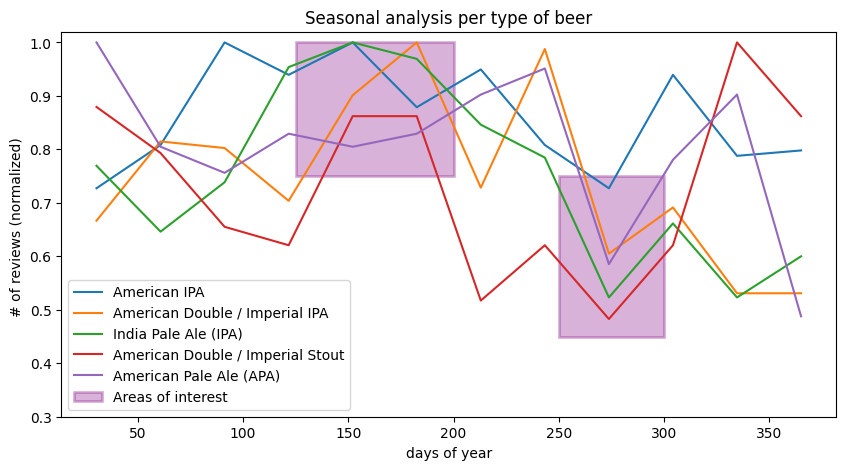

In [226]:
import matplotlib.patches as mpatches
most_represented = df_count_type_season.groupby(['style'])['style'] \
    .count() \
    .reset_index(name='count') \
    .sort_values(['count'], ascending=False) \
    .iloc[:5,0].values
#print(most_represented)
df_five_bests = df_count_type_season[df_count_type_season['style'].isin(most_represented)][['style','day_of_year']].reset_index()
#print(df_five_bests.head(20))
num_bins = 12
bins = 365/num_bins * np.arange(1, num_bins + 1)
#print(bins)
fig = plt.figure(figsize=(10,5))
for style in most_represented:
    counts = np.zeros((num_bins,1))
    for idx, samp in df_five_bests[df_five_bests['style'] == style].iterrows():
        pos = 0
        while samp['day_of_year'] > bins[pos] and pos < num_bins-1:
            pos += 1
        counts[pos] += 1
    plt.plot(bins,counts/max(counts), label=style)
    
# first area of interest
left, bottom, width, height = (250, 0.45, 50, 0.3)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=True,
                        color="purple",
                       linewidth=2,
                       alpha=0.3)
                       #facecolor="red")
                       #facecolor="red")
plt.gca().add_patch(rect)
    
# scd area of interest
left, bottom, width, height = (125, 0.75, 75, .25)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=True,
                        color="purple",
                       linewidth=2,
                       alpha=0.3,
                       label='Areas of interest')
                       #facecolor="red")
plt.gca().add_patch(rect)
plt.legend()
plt.xlabel('days of year')
plt.ylabel('# of reviews (normalized) ')
plt.title('Seasonal analysis per type of beer')
plt.ylim([.3,1.02])
plt.savefig('./')
print()

In [159]:

"""df_count_type_season = df_count_type_season[df_count_type_season['style'].isin(most_represented)] \
    .groupby(['style','day_of_year'])['date'].count_values()
print(type(df_count_type_season))
print(df_count_type_season)
df_count_type_season.plot()"""

AttributeError: 'SeriesGroupBy' object has no attribute 'count_values'

In [160]:
print(df_count_type_season.head())

num_bins = 10
bins = 365/num_bins * np.arange(1, num_bins + 1)
print(df_count_type_season[['day_of_year']])
print(pd.cut(df_count_type_season[['day_of_year']], 10))
groups = df_count_type_season.groupby(['style', df_count_type_season.cut(df_count_type_season.day_of_year, bins)])
print(groups.size().unstack())
groups.plot(type='line')

"""exit()

# for loop on the different type of beer
types = pd.unique(df_count_type_season['type'])

plt.figure(figsize=(5,5))
for beertype in types:
    df_count = df_count_type_season[df_count_type_season['type'] == beertype][day_of_year].group_by('day_of_year').count()
    print(df_count.iloc[:5])
    
    # count per day (or broader bins)
    # plot"""

                                  style        date  day_of_year  \
1013778  American Double / Imperial IPA  1434189600          164   
835526                          Old Ale  1356087600          356   
1516592                       Brown Ale  1354532400          338   
186130                  American Porter  1408269600          229   
1024842                 Specialty Grain  1169031600           17   

                  range  
1013778  (146.0, 182.5]  
835526   (328.5, 365.0]  
1516592  (328.5, 365.0]  
186130   (219.0, 255.5]  
1024842             nan  
         day_of_year
1013778          164
835526           356
1516592          338
186130           229
1024842           17
...              ...
520730           285
548102           160
932292           114
1405255          341
909799           129

[15517 rows x 1 columns]


ValueError: Input array must be 1 dimensional

## Number of review per day using rolling average

In [ ]:


# Assuming the file is named 'beer_ratings.csv' and is located in the same directory as your script.
# Read the CSV file
BA_NR_RW_DAY=ratings_BA
# Convert the Unix time to a datetime object, assuming the 'date' column is Unix time in seconds
BA_NR_RW_DAY['date'] = pd.to_datetime(BA_NR_RW_DAY['date'], unit='s')

# Filter out dates to ensure we only have one year of data, if necessary
start_date = "2015-01-1"  # start date in the example given (20th August 2015)
end_date = "2016-01-1"    # end date, one year later
BA_NR_RW_DAY_WW = BA_NR_RW_DAY[(BA_NR_RW_DAY['date'] >= start_date) & (BA_NR_RW_DAY['date'] <= end_date)]


In [ ]:
# Group by the date and count the reviews
def plot_rolling(df, window=7):
    daily_reviews = df.groupby(df['date'].dt.date).size()
    print(daily_reviews)
    # Calculate the moving average with a window size of 7 to remove weeks days
    rolling = daily_reviews.rolling(window=window, center=True)
    rolling_average = rolling.mean()
    
    # Plot the rolling average
    plt.figure(figsize=(14, 7))
    rolling_average.plot(title='Number of Reviews Per Day Over One Year')
    
    # Add labels and grid
    plt.xlabel('Date')
    plt.ylabel('Average Number of Reviews')
    plt.grid(True)
    plt.show()
plot_rolling(BA_NR_RW_DAY_WW)

In [ ]:
german_beers= ratings_BA[ratings_BA["brewery_id"].isin(breweries_BA[breweries_BA['location']=='Germany']['id'])]
german_beers['date'] = pd.to_datetime(german_beers['date'], unit='s')

# Filter out dates to ensure we only have one year of data, if necessary
start_date = "2015-01-1"  # start date in the example given (20th August 2015)
end_date = "2016-01-1"    # end date, one year later

german_beers_WW = german_beers[(german_beers['date'] >= start_date) & (german_beers['date'] <= end_date)]
plot_rolling(german_beers_WW)

In [ ]:
german_users= ratings_BA[ratings_BA["user_id"].isin(users_BA[users_BA['location']=='Germany']['user_id'])]
#german_beers['date'] = pd.to_datetime(german_beers['date'], unit='s')

# Filter out dates to ensure we only have one year of data, if necessary
start_date = "2015-01-1"  # start date in the example given (20th August 2015)
end_date = "2016-01-1"    # end date, one year later

german_users_WW = german_users[(german_users['date'] >= start_date) & (german_users['date'] <= end_date)]
plot_rolling(german_users_WW, 7)

## Alcohol by volume evolution in a mean year by country of user

In [66]:
alcohol_reviews = ratings_mixed_sample[['date','user_location','abv']]
alcohol_reviews = alcohol_reviews.dropna()

alcohol_reviews.loc[:,'date'] = alcohol_reviews[['date']].apply(lambda x: pd.to_datetime(x, unit='s'))
alcohol_reviews.loc[:,'time'] = alcohol_reviews.loc[:,'date'].apply(lambda x: x.year)
alcohol_reviews = alcohol_reviews.drop(columns = "date")
alcohol_reviews = alcohol_reviews[alcohol_reviews.groupby('user_location')['user_location'].transform('size') > 50000]
alcohol_reviews

,user_location,abv,time
1,"United States, New York",4.5,2009
10,"United States, Pennsylvania",4.8,2013
11,"United States, California",4.8,2013
13,"United States, New York",4.8,2013
16,"United States, Pennsylvania",4.8,2012
...,...,...,...
15516810,Denmark,4.0,2015
15516811,Denmark,4.0,2015
15516812,Denmark,4.0,2015
15516814,Denmark,4.0,2015


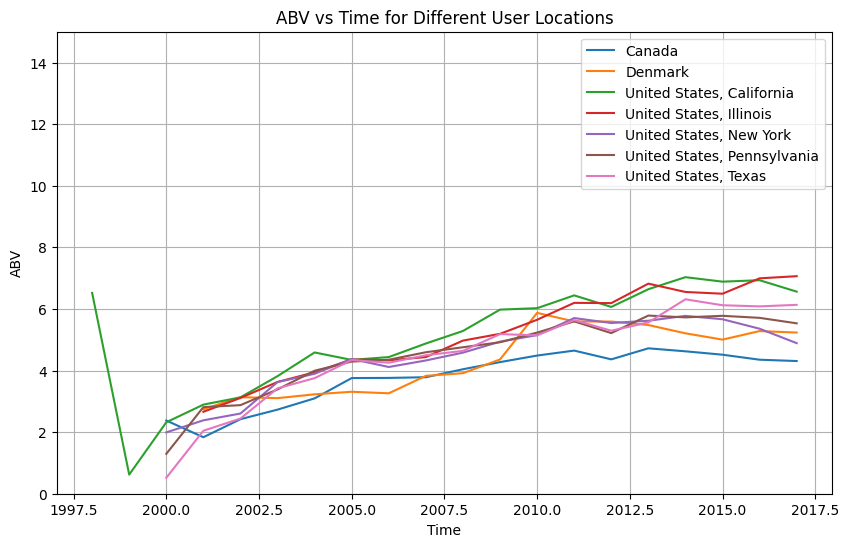

In [73]:
mean_abv = alcohol_reviews.groupby(["user_location", "time"]).var().reset_index()

# Create a plot with multiple lines and legend
plt.figure(figsize=(10, 6))

for location in mean_abv["user_location"].unique():
    location_data = mean_abv[mean_abv["user_location"] == location]
    plt.plot(location_data["time"], location_data["abv"], label=location)

plt.xlabel("Time")
plt.ylabel("ABV")
plt.ylim([0, 15])
plt.legend(loc="upper right")
plt.title("ABV vs Time for Different User Locations")
plt.grid(True)
plt.show()

user_location
Canada                         [[Axes(0.125,0.11;0.775x0.77)]]
Denmark                        [[Axes(0.125,0.11;0.775x0.77)]]
United States, California      [[Axes(0.125,0.11;0.775x0.77)]]
United States, Illinois        [[Axes(0.125,0.11;0.775x0.77)]]
United States, New York        [[Axes(0.125,0.11;0.775x0.77)]]
United States, Pennsylvania    [[Axes(0.125,0.11;0.775x0.77)]]
United States, Texas           [[Axes(0.125,0.11;0.775x0.77)]]
dtype: object

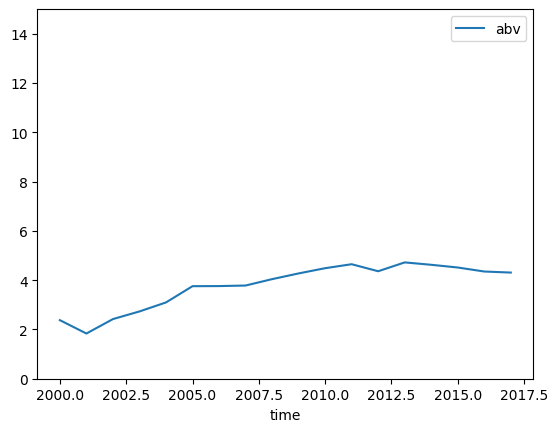

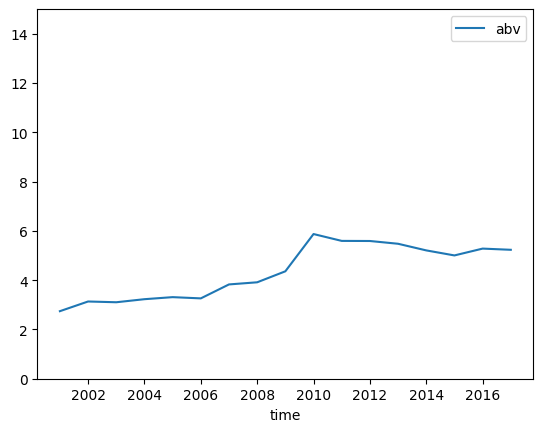

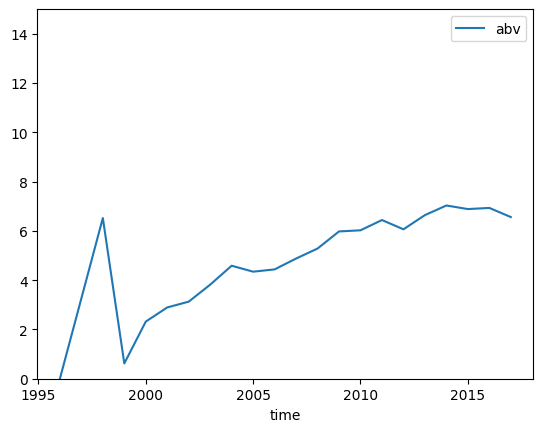

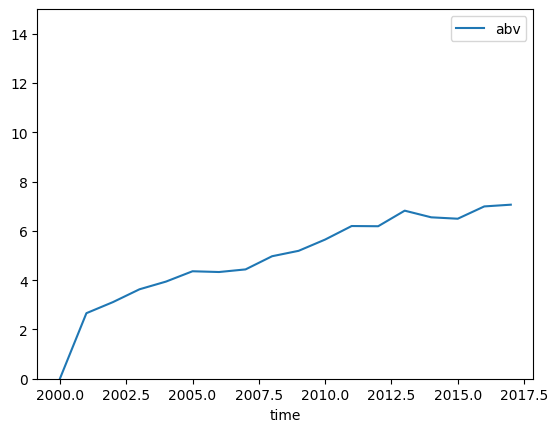

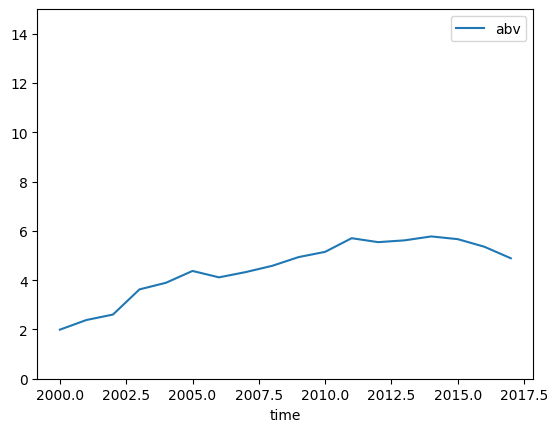

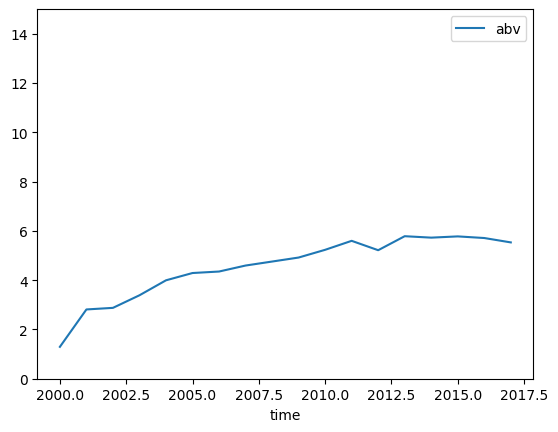

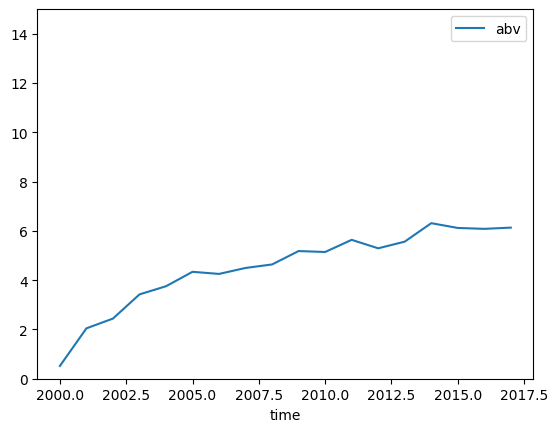

In [72]:
mean_abv = alcohol_reviews.groupby(["user_location", "time"]).var().reset_index()
mean_abv.groupby("user_location").plot(x="time", y='abv', kind='line', ylim=[0, 15], subplots=True, sharex=False, sharey=True, layout= (1, -1), stacked=True, use_index=True)

<Axes: xlabel='time'>

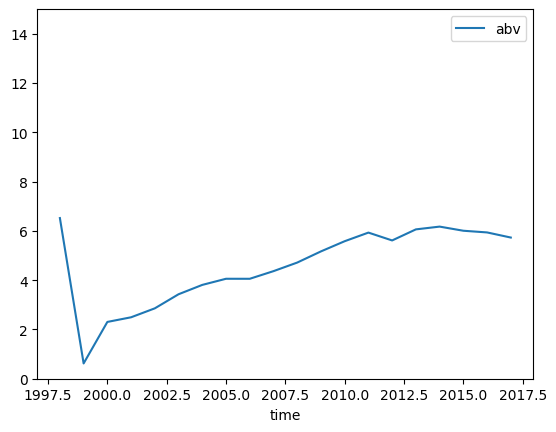

In [71]:
alcohol_reviews_global = alcohol_reviews.drop(columns='user_location')
mean_abv = alcohol_reviews_global.groupby(["time"]).var().reset_index()
mean_abv.plot(x="time", y='abv', kind='line', ylim=[0, 15])

<Axes: xlabel='time'>

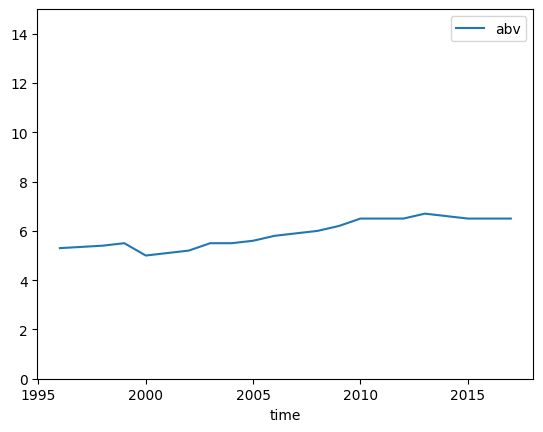

In [55]:
mean_abv = alcohol_reviews.groupby(["time"]).median().reset_index()
mean_abv.plot(x="time", y='abv', kind='line', ylim=[0, 15] )

<Axes: xlabel='time'>

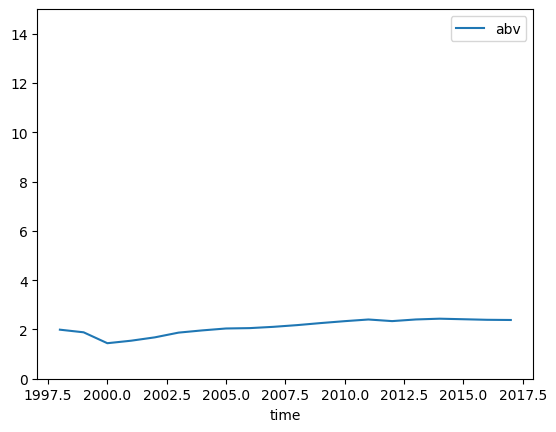

In [56]:
mean_abv = alcohol_reviews.groupby(["time"]).std().reset_index()
mean_abv.plot(x="time", y='abv', kind='line', ylim=[0, 15] )

## Analysis 4